```sh
mkdir un_repertoire
cd un_repertoire
setconda
conda activate tyssue
jupyter notebook --no-browser
```

OR 

```sh
conda create -n tyssue python=3.8
conda activate tyssue
conda install -c conda-forge tyssue
jupyter notebook
```

```sh
wget https://github.com/sophietheis/Workshop-Cell-Dynamics-WS/archive/master.zip
unzip master.zip
```
OR

```sh
git clone https://github.com/sophietheis/Workshop-Cell-Dynamics-WS.git
```

In [1]:
import tyssue

conda install - conda-forge mamba

# Workshop outline & objectives


Welcome to the « Modeling Morphogenesis in 2D and 3D » workshop.

In this workshop, we'll use the [tyssue](https://tyssue.readthedocs.io) to explore the basics of vertex based modeling of epithelium in 2D and 3D.

You'll learn how to use the library to desing epithelium simulation from the basic cell level morphogenetic events up.

At the end of the workshop, we'll look into a "full" simulation and discuss what it would take to create a paper from it.




## Outline


### [Introduction](#Introduction-to-the-tyssue-library)



### [1 - Quasi-static models](#Quasi-static-models)

### [2 - Cell rearangements](#Cell-rearangements)

### [3 - Modeling cell migration](#Modeling-cell-migration)



# Introduction to the tyssue library


The Tyssue python library allows to model mechanical behavior of 2D, apical 3D or full 3D epithelia.


![dimension](illus/dimension.png)

## Generate a 2D epithelium


For this, we use a **Voronoï tessalation** of the cell centers.


![tessalation gif](illus/tessalation.gif)



In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ipywidgets as widgets
from IPython import display
import ipyvolume as ipv

# Core object
from tyssue import Sheet
# Simple 2D geometry
from tyssue import PlanarGeometry as sgeom
# Visualisation
from tyssue.draw import (
    sheet_view,
    highlight_faces,
    create_gif,
    browse_history
)

sheet = Sheet.planar_sheet_2d(
    'basic2D', # a name or identifier for this sheet
    nx=6, # approximate number of cells on the x axis
    ny=7, # approximate number of cells along the y axis
    distx=1, # distance between 2 cells along x
    disty=1, # distance between 2 cells along y
    noise=0 # some position noise
)
sgeom.update_all(sheet)

# Give the tissue a nice hear cut ;)
sheet.sanitize(trim_borders=True, order_edges=True)
sgeom.update_all(sheet)

> Change the above parameters to see what happens

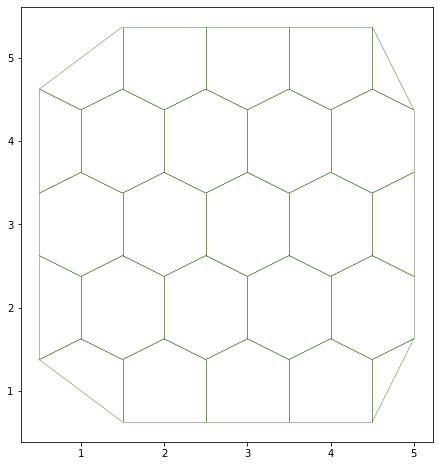

In [24]:
# Visualisation of the tissue
fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)

## Data structure


The tyssue library defines tissue as a meshes. A vertex model defines a tissue as an assembly of vertices and edges, which can form polygonal face (in 2D) or polyhedron (in 3D). 

![vertex](illus/vertexmodel.png)

The data associated with the mesh displayed above, i.e. the points positions, the connectivity information, etc. is stored in pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) objects, hold together in the `datasets` dictionnary.

Depending on the geometry, the following dataframes are populated:

- `datasets["edge"]` or `sheet.edge_df`: The edge related dataframe contains

    - the connectivity information: source and target vertices, associated face and (for thick tissues) the associated cell body.
    - geometry data associated with the edge, such as its length
    - any suplemental data, such as a color or a dynamical parameter (an elasticity for example)
    
- `datasets["vert"]` or `sheet.vert_df`: The vertices related dataframe. In the apical junction mesh above, those are the vertices at the cells junctions. It usually holds the coordinates of the points, and geometry or dynamical data.

- `datasets["face"]` or `sheet.face_df`: The faces related dataframe. For a thin, 2D tissue, this corresponds to a cell of the epithelium, delimited by its edges. In thick, 3D models, one cell has several faces (the apical, sagittal and basal ones for a 3D monolayer, for example).


- `datasets["cell"]` or `sheet.cell_df`: The cells related dataframe, only for 3D, thick, epithelium. Each cell have several faces.

### We use _half-edges_

Between two faces, an edge (a junction) is described by two entries in `sheet.edge_df`, one for each face. This simplifies some computations and algorithms, and allows to address each side of the junction separately.

![Half edges](illus/double_edges.svg)

### Coordinate system and columns in the dataframes


In the above image, you can see the definition of the various coordinates stored in `edge_df`:

- "fx, fy" : the position of the half-edge's face center
- "sx, sy" : the position of the half-edge's source vertex
- "tx, ty" : the position of the half-edge's target vertex
- "dx, dy" : the coordinates of the half-edge's supporting vector
- "ux, uy" : the coordinates of the half-edge's unitary vector (`ux = dx / sqrt(dx**2 + dy**2)`)
- "rx, ry" : the positon of the source vertex relative to the face center





In [4]:
sheet.edge_df.head(5)

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,ty,fx,fy,ux,uy,rx,ry,sub_area,is_valid,phi
edge,,,,,,,,,,,,,,,,,,,,
0,30,0.28125,0.750000,0,28,0.0,0.75,1.5,0.625,1.5,1.375,1.125,1.250,0.000000,1.000000,0.375,-0.625,0.140625,True,-0.643501
1,9,0.15625,0.559017,0,30,-0.5,0.25,1.5,1.375,1.0,1.625,1.125,1.250,-0.894427,0.447214,0.375,0.125,0.078125,True,0.643501
2,5,0.21875,0.559017,0,9,-0.5,-0.25,1.0,1.625,0.5,1.375,1.125,1.250,-0.894427,-0.447214,-0.125,0.375,0.109375,True,1.570796
3,28,0.34375,1.250000,0,5,1.0,-0.75,0.5,1.375,1.5,0.625,1.125,1.250,1.788854,-1.341641,-0.625,0.125,0.171875,True,1.570796
4,43,0.37500,0.750000,1,29,0.0,0.75,2.5,0.625,2.5,1.375,2.000,1.125,0.000000,1.000000,0.500,-0.500,0.187500,True,-0.643501


In [27]:
sheet.face_df.tail(5)

,y,is_alive,perimeter,area,x,num_sides,id
face,,,,,,,
20,4.750000,1,3.118034,0.5000,1.125000,4,0
21,4.875000,1,3.618034,0.8750,2.000000,5,0
22,4.875000,1,3.618034,0.8750,3.000000,5,0
23,4.875000,1,3.618034,0.8750,4.000000,5,0
24,4.791667,1,2.427051,0.1875,4.666667,3,0


In [6]:
sheet.vert_df.head(5)

,y,is_active,x
vert,,,
0,3.625,1,1.0
1,3.375,1,0.5
2,4.625,1,0.5
3,4.375,1,1.0
4,3.375,1,1.5


## Modifying the geometry


Most columns in the above dataframes are computed when the `geom.update_all` function is called. They depend only on the positions of the vertices, stored in `sheet.vert_df[['x', 'y']]`:

* The edge length are simply $\sqrt(x^2 + y^2)$ (Pythagoras represents).
* The face centers are the center of mass of the vertices positions. 

> Can you guess how the face areas are computed?

If we change those positions, we change all the values depending on them.

We can also see statistics or compute various derivated quantities.


In [7]:
avg_area = sheet.face_df['area'].mean()

print("Average cells area: ", avg_area)

Average cells area:  0.805


In [28]:
sheet.edge_df["length"].min()

0.5590169943749475

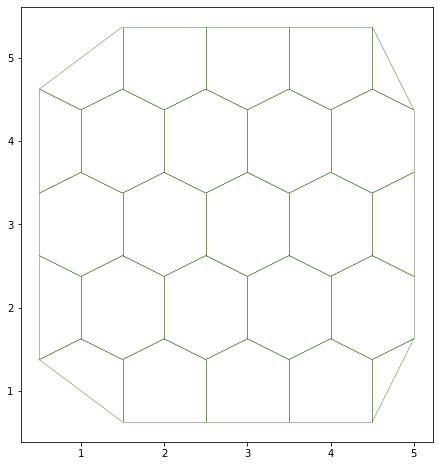

In [30]:
sheet.vert_df['x'] = sheet.vert_df['x'] * 5
sgeom.update_all(sheet)

fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)

> **exercice**
>
> Rescale the sheet correctly

<details><summary><b>Solution →</b></summary>

```py
sheet.vert_df['x'] = sheet.vert_df['x'] / 5
geom.update_all(sheet)
```

</details>

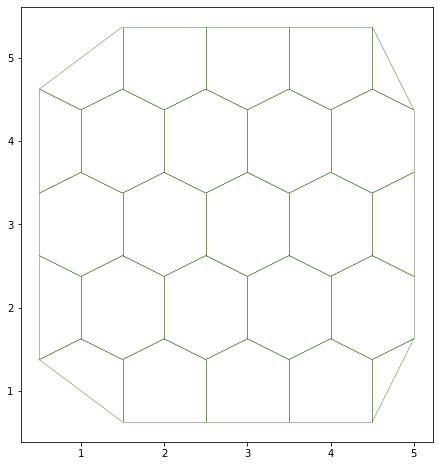

In [32]:
# Write the solution here
#
sheet.vert_df['x'] = sheet.vert_df['x'] * 5
sgeom.update_all(sheet)

fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)

> **exercice**
>
> Change the vertex positions so that the average area is close to 1.0, and update the geometry

<details><summary><b>Solution →</b></summary>

```py
sheet.vert_df[['x', 'y']] /= sheet.face_df.area.mean()
sgeom.update_all(sheet)
```

</details>

In [34]:
# Write the solution here
sheet.vert_df[['x', 'y']] = sheet.vert_df[['x', 'y']] / sheet.face_df.area.mean()
sgeom.update_all(sheet)

# Quasi-static models


A common way to describe an epithelium is with the **quasistatic approximation**: we assume that at any point in time, without exterior perturbation, the epithelium is at an **energy minimum**. For a given expression of the model's Hamiltonian, we thus search the position of the vertices corresponding to the minimum of energy.

## The Farhadifar model

A very common formulation for the epithelium mechanical energy was given in [Farhadifar et al. in 2007](https://doi.org/10.1016/j.cub.2007.11.049).

The energy is the sum of an area elasticity, a contractility and a line tension:
$$
E = \sum_\alpha \frac{K_A}{2}(A_\alpha - A_0)^2 + \sum_\alpha \Gamma P_\alpha^2 + \sum_{ij} \Lambda \ell_{ij} 
$$

In tyssue, `Model` objects provide functions to compute the energy for a given epithelium,  as well as it's spatial derivatives over the vertices positions, the gradient.


The calculus is done with the columns of the dataframes, for exemple, if we set the value 0.12 for the term $\Lambda$ for all the edges of the epithelium:



In [9]:
sheet.edge_df["line_tension"] = 0.12
E_lt = (sheet.edge_df["length"] * sheet.edge_df["line_tension"]).sum()
print("Line tension energy : ", E_lt)

Line tension energy :  31.48737602344666


> **exercice**
>
> Add a "contractily" column in `sheet.face_df` with value 0.07
> & compute the energy associated with the contractility term above

<details><summary><b>Solution →</b></summary>

```py
sheet.face_df["contractility"] = 0.04
E_lt = (sheet.face_df["contractility"] * sheet.face_df["perimeter"]**2).sum()
print("Contractility energy : ", E_lt)
```

</details>

In [10]:
# Write the solution here
sheet.face_df["contractility"] = 0.07
E_cr = (sheet.face_df["contractility"] * sheet.face_df["perimeter"]**2).sum()
print("Contractility energy : ", E_lt)

Contractility energy :  114.05323601296841


This model has been predifined in tyssue as the default `PlanarModel`. We can use it in combination with a `Solver` object to find the energy minimum of our sheet.

To add the various columns in the dataframes (as we did above) we use a  **specification dictionnary** with the required parameters.

In [35]:
#from tyssue.config.dynamics import quasistatic_plane_spec
from tyssue.dynamics.planar_vertex_model import PlanarModel as smodel
from tyssue.solvers import QSSolver
from pprint import pprint

specs = {
    'edge': {
        'is_active': 1,
        'line_tension': 0.12,
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0
    },
   'face': {
       'area_elasticity': 1.0,
       'contractility': 0.04,
       'is_alive': 1,
       'prefered_area': 1.0},
   'settings': {
       'grad_norm_factor': 1.0,
       'nrj_norm_factor': 1.0
   },
   'vert': {
       'is_active': 1
   }
}


# Update the specs (adds / changes the values in the dataframes' columns)
sheet.update_specs(specs)

pprint(specs)

{'edge': {'is_active': 1,
          'line_tension': 0.12,
          'ux': 0.0,
          'uy': 0.0,
          'uz': 0.0},
 'face': {'area_elasticity': 1.0,
          'contractility': 0.04,
          'is_alive': 1,
          'prefered_area': 1.0},
 'settings': {'grad_norm_factor': 1.0, 'nrj_norm_factor': 1.0},
 'vert': {'is_active': 1}}


In [36]:
E_t = smodel.compute_energy(sheet)
print("Total energy: ", E_t)

Total energy:  12.679774735886998


In [39]:
smodel.compute_gradient(sheet).head()

,gx,gy
srce,,
0,-2.677997e-01,0.100401
1,-3.380361e-02,0.002999
2,1.150356e-01,-0.057518
3,-2.677997e-01,0.167398
4,3.053113e-16,0.035599


The energy minimum is found with a _gradient descent_ strategy, the vertices are displaced in the direction opposit to the spatial derivative of the energy. Actually, this defines the **force** on the vertices.


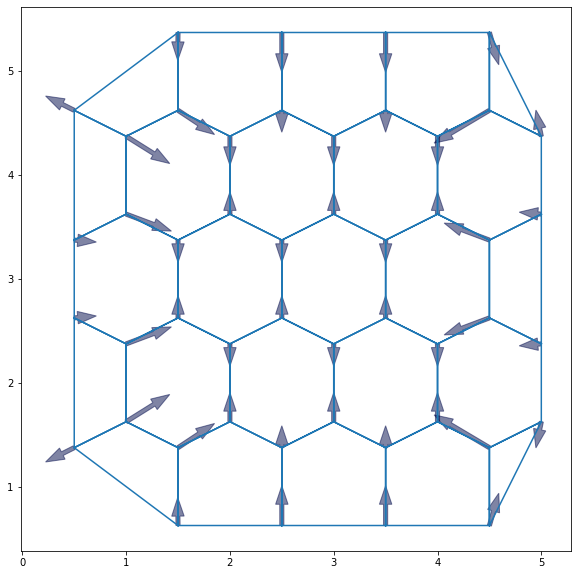

In [40]:
from tyssue.draw.plt_draw import plot_forces

fig, ax = plot_forces(sheet, sgeom, smodel, ['x', 'y'], 1)

fig.set_size_inches(10, 10)
ax.set_aspect('equal')

Successfull gradient descent?  True


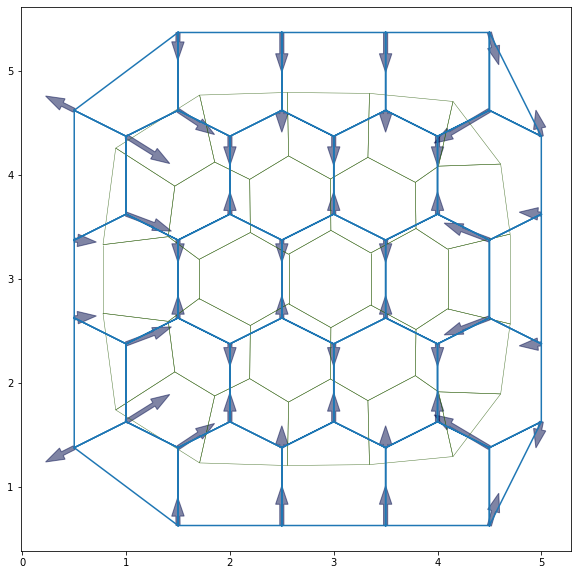

In [41]:
# Find energy minimum
solver = QSSolver()
res = solver.find_energy_min(sheet, sgeom, smodel)

print("Successfull gradient descent? ", res['success'])
fig, ax = sheet_view(sheet, ax=ax)

fig.set_size_inches(10, 10)
ax.set_aspect('equal')

fig

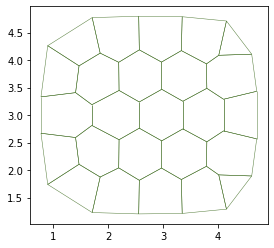

In [42]:
fig, ax = sheet_view(sheet)

In [45]:
sheet.edge_df["line_tension"].head()

edge
0    0.12
1    0.12
2    0.12
3    0.12
4    0.12
Name: line_tension, dtype: float64

In [ ]:
sheet.edge_df.loc[0, "line_tension"] = 0


# Simulating epithelium growth 


## Cell growth

> **exercice**
>
> How would you simulate a single cell growth?

**Hint**: You can use [`loc`](https://pandas.pydata.org/docs/user_guide/indexing.html#selection-by-label) to access an element or a subelement of the dataframes. You can inspect `quasistatic_plane_spec()` to find the relevant columns.

<hr/>

<details><summary><b>Solution →</b></summary>
By increasing the equilibrium area of this cell:

```py
sheet.face_df.loc[12, "perefered_area"] *= 1.5
solver.find_energy_min(sheet, sgeom, model)    
```
</details>

In [46]:
sheet.face_df.columns

Index(['y', 'is_alive', 'perimeter', 'area', 'x', 'num_sides', 'id',
       'area_elasticity', 'contractility', 'prefered_area'],
      dtype='object')

In [49]:
# Write the solution here
sheet.face_df.loc[12, "prefered_area"] *= 1.5
res = solver.find_energy_min(sheet, sgeom, smodel)

      fun: 11.77950751419055
 hess_inv: <96x96 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.21191767e-04, -1.04878470e-04, -5.07457872e-05,  4.70621055e-04,
        9.10735983e-04,  4.99936771e-05,  8.22785335e-04,  2.49743157e-05,
       -5.18960276e-04,  8.18925349e-04,  9.10735983e-04, -4.99936771e-05,
       -5.07457872e-05, -4.70621055e-04, -1.52762935e-03,  1.41932953e-03,
        1.60477076e-03, -1.13877188e-03,  8.22785335e-04, -2.49743157e-05,
       -5.18960276e-04, -8.18925349e-04,  9.21191767e-04,  1.04878470e-04,
        1.08249494e-03, -5.91371224e-04,  3.72514921e-05,  3.53430116e-04,
        4.43567725e-04,  1.41720361e-03, -4.17436321e-04, -2.47817646e-04,
       -9.46536534e-04,  8.99062148e-04,  3.90221408e-04,  1.99749033e-03,
       -2.74337571e-04, -8.20676949e-04, -4.28668665e-04, -8.34002252e-04,
       -9.46536534e-04, -8.99062148e-04,  5.70883139e-04, -3.78739851e-04,
       -4.93326852e-04,  8.37013382e-04, -1.33169359e-03, -8.57566437e-04,
  

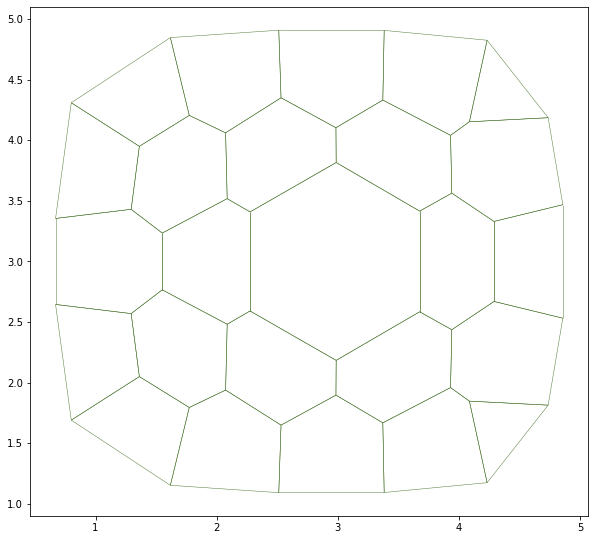

In [50]:
fig, ax = sheet_view(sheet)

fig.set_size_inches(10, 10)
ax.set_aspect('equal')

## Mitosis


Mitosis is the last step of cell division, when the septum splits the mother cell in 2. In 2D vertex models, it consists in putting a new edge in the dividing face.

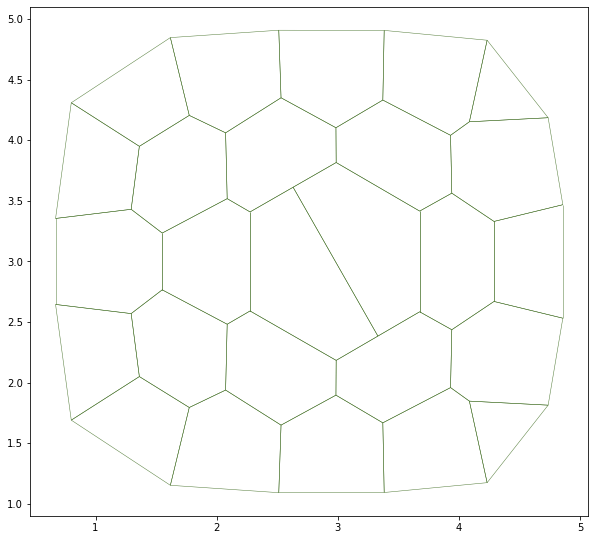

In [51]:
from tyssue.topology.sheet_topology import cell_division

# reset prefered_area
sheet.face_df.loc[12, "prefered_area"] = 1.0

daughter = cell_division(sheet, 12, sgeom)
sgeom.update_all(sheet)
fig, ax = sheet_view(sheet)

fig.set_size_inches(10, 10)
ax.set_aspect('equal')

In [52]:
daughter

25

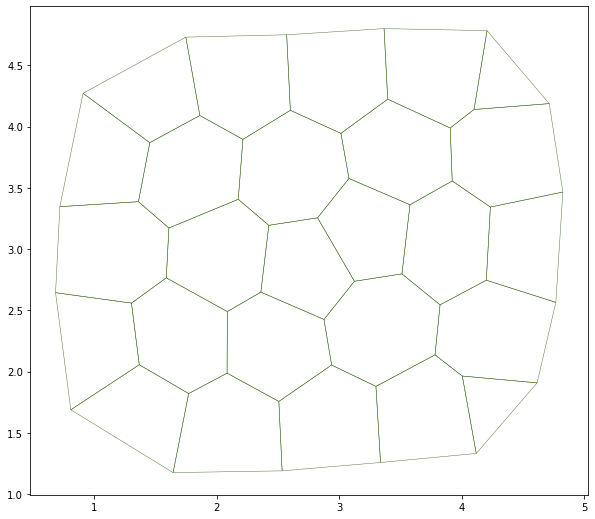

In [53]:
solver.find_energy_min(sheet, sgeom, smodel)  
fig, ax = sheet_view(sheet)

fig.set_size_inches(10, 10)
ax.set_aspect('equal')

## Growth and division


As we simulate living tissues, each cell is an _agent_ that can adopt certain _behaviors_. Those depend on biological signals (information) and bio-mechanical regulation.

In tyssue, this is modeled by "atomic" _actions_ combined in _behavior_ functions through conditionals, managed by an `EventManager` object. The event manager holds a todo lists for the current time step and the next. It goes through the current behavior list, possibliy add 


> **exercice**
>
> What are the atomic actions governing cell division?


<hr/>

<details><summary><b>Solution →</b></summary>

![Division flow diagram](illus/division_diag.svg)


</details>


> **exercice**
>
> Fill the blanks below


In [55]:
from tyssue.behaviors import EventManager
from tyssue import History

def division(sheet, manager, cell_id=0, crit_area=2.0, growth_rate=0.1, dt=1.):
    """Defines a division behavior.
    
    Parameters
    ----------
    
    sheet: a :class:`Sheet` object
    cell_id: int
        the index of the dividing cell
    crit_area: float
        the area at which 
    growth_rate: float
        increase in the prefered are per unit time
        A_0(t + dt) = A0(t) * (1 + growth_rate * dt)
    """

    
    if sheet.face_df.loc[cell_id, "area"] > crit_area:
        # restore prefered_area
        sheet.face_df.loc[12, "prefered_area"] = 1.0
        # Do division
        daughter = cell_division(sheet, cell_id, sgeom)
        # Update the topology
        sheet.reset_index(order=True)
        # update geometry
        sgeom.update_all(sheet)
        print(f"cell n°{daughter} is born")
        manager.append(division, cell_id=daughter)
    else:
        # 
        sheet.face_df.loc[12, "prefered_area"] *= (1 + dt * growth_rate)
    
    manager.append(division, cell_id=cell_id)
    


<details><summary><b>Solution →</b></summary>

```py
def division(sheet, manager, cell_id=0, crit_area=2.0, growth_rate=0.1):
    """Defines a division behavior.
    
    Parameters
    ----------
    
    sheet: a :class:`Sheet` object
    cell_id: int
        the index of the dividing cell
    crit_area: float
        the area at which 
    growth_rate: float
        increase in the prefered are per unit time
        A_0(t + dt) = A0(t) * (1 + growth_rate * dt)
    """
    dt = manager.dt
    
    if sheet.face_df.loc[cell_id, "area"] > crit_area:
        # restore prefered_area
        sheet.face_df.loc[cell_id, "prefered_area"] = 1.0
        # Do division
        daughter = cell_division(sheet, cell_id, sgeom)
        sgeom.update_all(sheet)
        
        print(f"cell n°{daughter} is born")
        manager.append(division, cell_id=daughter)
    else:
        sheet.face_df.loc[cell_id, "prefered_area"] *= (1 + dt * growth_rate)
    manager.append(division, cell_id=cell_id)

```
</details>

    

In [56]:
manager = EventManager("face")

manager.append(division, cell_id=12)
manager.dt = 1.

t = 0
stop = 30

progress = widgets.IntProgress(min=0, max=stop)
progress.value = 0
display.display(progress)

# The History object records all the time steps 
history = History(sheet)

while manager.current and t < stop:
    manager.execute(sheet)
    t += 1
    progress.value = t
    sheet.reset_index(order=True)
    res = solver.find_energy_min(sheet, sgeom, smodel)
    history.record()
    manager.update()

IntProgress(value=0, max=30)

cell n°26 is born
cell n°27 is born
cell n°28 is born
cell n°29 is born


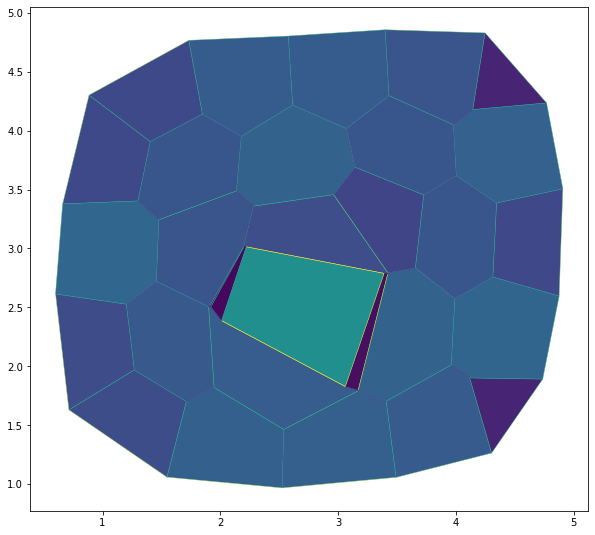

In [57]:
draw_specs = {
    "edge": {
        "color": lambda sheet: sheet.edge_df.length
    },
    "face": {
        "visible": True,
        "color": lambda sheet: sheet.face_df.area,
        "color_range": (0, 2)
    }
}

fig, ax = sheet_view(sheet, mode='2D', **draw_specs)
fig.set_size_inches(10, 10)
ax.set_aspect('equal')


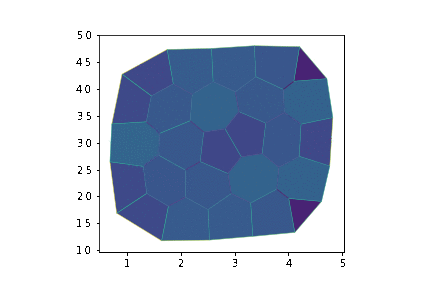

In [58]:
create_gif(history, "growth.gif", num_frames=30, margin=5, **draw_specs)
display.Image("growth.gif")

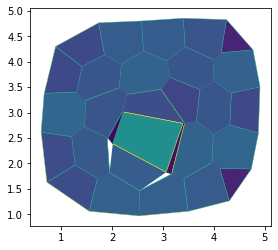

In [59]:
sheet.reset_index(order=True)
fig, ax = sheet_view(sheet, mode='2D', **draw_specs)


### Cell division in a 3D monolayer

In [62]:
!cp /usr/local/conda/envs/tyssue/lib/python3.7/site-packages/tyssue/stores/small_ellipsoid.hf5 .

cp: impossible d'évaluer '/usr/local/conda/envs/tyssue/lib/python3.7/site-packages/tyssue/stores/small_ellipsoid.hf5': Aucun fichier ou dossier de ce type


In [60]:
from tyssue import Monolayer
from tyssue.geometry.bulk_geometry import ClosedMonolayerGeometry as mgeom
from tyssue.dynamics.bulk_model import ClosedMonolayerModel as mmodel
from tyssue.draw import highlight_cells
from tyssue.io.hdf5 import load_datasets
from tyssue.stores import stores_dir 
from pathlib import Path

datasets = load_datasets(Path(stores_dir)/'small_ellipsoid.hf5')

monolayer = Monolayer('ellipsoid', datasets)


mgeom.update_all(monolayer)

mgeom.scale(
    monolayer,
    monolayer.cell_df.vol.mean()**(-1/3),
    monolayer.coords
)

mgeom.update_all(monolayer)

specs = {
    "edge": {
        "line_tension": 0.0,
        "is_active": 1
    },
    "face": {
        "contractility": 0.0,
    },
    "cell": {
        "prefered_vol": 1.0,
        "vol_elasticity": 0.1,
        "prefered_area": monolayer.cell_df['area'].median()*0.8,
        "area_elasticity": 0.1,
    },
    "settings": {
        'lumen_prefered_vol': monolayer.settings['lumen_vol']*1.2,
        'lumen_vol_elasticity': 1e-2
    }
}

monolayer.update_specs(specs, reset=True)
monolayer.cell_df['id'] = monolayer.cell_df.index
res = solver.find_energy_min(monolayer, mgeom, mmodel)



Reseting column line_tension of the edge dataset with new specs
Reseting column contractility of the face dataset with new specs
Reseting column prefered_vol of the cell dataset with new specs
Reseting column vol_elasticity of the cell dataset with new specs


In [61]:
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D", coords=['z', 'x', 'y'], **draw_specs)
fig


Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

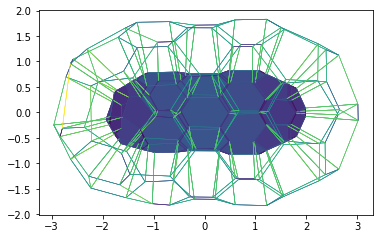

In [67]:
fig, mesh = sheet_view(monolayer, mode="2D", coords=['z', 'y'], **draw_specs)


In [63]:
monolayer.face_df['visible'] = monolayer.face_df.segment == "basal"

ipv.clear()
ipv.style.use("light")
fig, mesh = sheet_view(monolayer, mode="3D", coords=['z', 'x', 'y'], **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [64]:
mmodel.labels

['Line tension',
 'Contractility',
 'Area elasticity',
 'Volume elasticity',
 'Lumen volume elasticity']

In [65]:
monolayer.cell_df.vol.mean()

0.803747338514151

In [68]:
from tyssue.topology.monolayer_topology import cell_division
def division(monolayer, manager, cell_id=0, crit_volume=1.2, growth_rate=0.1, dt=1):
    """Defines a division behavior.

    Parameters
    ----------

    sheet: a :class:`Sheet` object
    cell_id: int
        the index of the dividing cell
    crit_area: float
        the area at which 
    growth_rate: float
        increase in the prefered are per unit time
        A_0(t + dt) = A0(t) * (1 + growth_rate * dt)
    """
    if monolayer.cell_df.loc[cell_id, "vol"] > crit_volume:
        
        monolayer.cell_df.loc[cell_id, "prefered_vol"] = 1.0
        daughter = cell_division(monolayer, cell_id, orientation="apical")
        monolayer.reset_index(order=True)
        mgeom.update_all(monolayer)
        print(f"cell n°{daughter} is born")
        
        manager.append(division, cell_id=daughter)
    else:
        monolayer.cell_df.loc[cell_id, "prefered_vol"] *= (1 + dt * growth_rate)

    manager.append(division, cell_id=cell_id)

In [73]:
# reset face visualisation
monolayer.face_df['visible'] = True

manager = EventManager("cell")

manager.append(division, cell_id=12)

t = 0
stop = 25

progress = widgets.IntProgress(min=0, max=stop)
progress.value = 0
display.display(progress)

# The History object records all the time steps 
history = History(monolayer)

while manager.current and t < stop:
    
    manager.execute(monolayer)
    t += 1
    progress.value = t
    monolayer.reset_index(order=True)
    res = solver.find_energy_min(monolayer, mgeom, mmodel)
    history.record()
    manager.update()

IntProgress(value=0, max=25)

cell n°48 is born


In [74]:
monolayer.validate()

True

In [75]:

ipv.clear()
browse_history(history, **draw_specs)

interactive(children=(IntSlider(value=0, description='i', max=25), Output()), _dom_classes=('widget-interact',…

In [76]:
monolayer.face_df.segment.unique()

array(['apical', 'basal', 'sagittal'], dtype=object)

In [77]:
monolayer.face_df['visible'] = monolayer.face_df.segment == "sagittal"

ipv.clear()
ipv.style.use("dark")
fig, mesh = sheet_view(monolayer, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

# Cell rearangements

## Topological changes in 2D: type 1 transitions


We saw with multiple cell division that deformation accumulate in our simulated epithelium in a non physiological (to say the least) fashion.

This is because we lacked a mechanism allowing cells to rearange in the tissue. This reorganisation takes place through the process of type 1 transitions.

![Type 1 transition](illus/t1_transition.svg)





> **exercice**
> Display an histogramm of the edge lengths in the sheet and the monolayer

<details><summary><b>Solution →</b></summary>

```python
fig, ax = plt.subplots()
_ = ax.hist(sheet.edge_df.length, range=(0, 2), bins=32, density=True)
_ = ax.hist(monolayer.edge_df.length, range=(0, 2), bins=32, rwidth=0.5, density=True)  

```

</details>

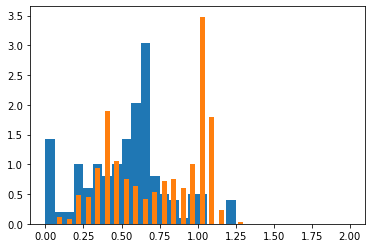

In [78]:
fig, ax = plt.subplots()
_ = ax.hist(sheet.edge_df.length, range=(0, 2), bins=32, density=True)
_ = ax.hist(monolayer.edge_df.length, range=(0, 2), bins=32, rwidth=0.5, density=True)  


> **exercice**
> How many edges in the sheet measure less than 0.01?

<details><summary><b>Solution →</b></summary>

```python
print((sheet.edge_df.length < 0.01).sum())
```

</details>

In [ ]:
# write your solution

In [79]:
from tyssue.topology.sheet_topology import type1_transition

In tyssue, type 1 transition is a function that takes a sheet and an edge index as argument:

```python
type1_transition(sheet, shortest, remove_tri_faces=False)
```

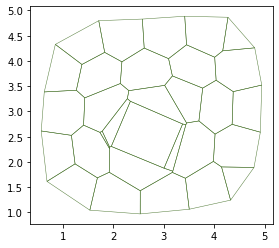

In [80]:
while (sheet.edge_df.length < 0.01).sum():
    shortest = sheet.edge_df.length.idxmin()
    type1_transition(sheet, shortest, remove_tri_faces=False)
    sgeom.update_all(sheet)
    solver.find_energy_min(sheet, sgeom, smodel)
    

fig, ax = sheet_view(sheet)

(Actually tyssue allows to decompose the type 1 transition in first a 4-way vertex formation followed by a detachement)

## Rearangements in 3D


![rearangement in 3D](illus/IH_transition.png)

# Modeling cell migration



We want to model the movement of a single cell accross an epithelium. We will use a model developed by the team of Lisa Manning showing transition from liquid to jamed epithelium [Dapeng Bi et al.](https://arxiv.org/abs/1409.0593v4).

The model reads as:

$$\epsilon = \sum_\alpha \left[ (a_\alpha - 1)^2 + \frac{(p_\alpha - p_0)^2}{r}\right]$$

Rearangements are discribed [Finegan et al.](https://doi.org/10.1101/704932)



<hr/>


## Defining new interaction terms 

As we have seen, models are defined as a sum of terms (area elasticity, line tension, etc.). In tyssue each of those terms are defined by an `effector` object. The monolayer model is defined by a list of five **effectors**:

In [81]:
print('Monlayer model effectors :', end='\n\t')
print(*mmodel.labels, sep="\n\t")

Monlayer model effectors :
	Line tension
	Contractility
	Area elasticity
	Volume elasticity
	Lumen volume elasticity



An effector designates a dynamical term in the epithelium governing equation. For quasistatic models, we need to provide  a method to compute the energy associated with this effector, and the corresponding gradient. 

### The line tension effector

For example, we can consider a line tension effector. The energy is $E_t = \sum_{ij} \Lambda\ell_{ij}$ where the sum is over all the edges. In order to compute the gradient over the positions, we need to compute $\nabla_i\,\Lambda\ell_{ij}$ (gradient at the source) and $\nabla_j\,\Lambda\ell_{ij}$ (gradient at the target).

We then have 2$N_e$ terms that can be factored for exemple for coordinate $x$ of vertex $i$:

$$
\frac{\partial E_t}{\partial x_i}
= \Lambda\left(\sum_k \frac{\partial}{\partial x_i} \ell_{ik} + \sum_m \frac{\partial}{\partial x_i} \ell_{mi}\right)
= \Lambda\left(\sum_k \frac{x_i}{\ell_{ik}}  - \sum_m \frac{x_i}{\ell_{mi}}\right)
$$

(notice the order of the indices $i$, $k$ and $m$)

Where $\sum_k$ is are over all the edges which vertex $i$ is a source, and $\sum_m$ over all the edges of which vertex i is a target. 


Here is the definition of the line tension effector:
```python
class LineTension(AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension"
    label = "Line tension"
    element = "edge"
    specs = {"edge": {"is_active": 1, "line_tension": 1e-2}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension * is_active * length / 2"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt
```


#### Unpacking the gradient expression:

For the line tension, the gradient from the half-edge of which the vertex is a source has a norm equal to the `line_tension` column and is parallel and in opposite direction to the unit vector of the half-edge, `sheet.edge_df[["ux", "uy", "uz"]]`. The gradient from the half_edge of witch the vertex is the target is in the same direction of the unit vector.


$$ \sum F  = 0 $$

$$ \sum F  = \eta \mathbf{v} $$


$$ v = dr/ dt \Rightarrow \sum F / \eta = dr / dt ; r(t+dt) = 1 / \eta \sum F \, dt + r(t)$$

In [82]:
from tyssue.solvers.viscous import EulerSolver
from tyssue.draw import sheet_view

from tyssue.dynamics import model_factory, effectors

from tyssue.behaviors import EventManager
from tyssue.behaviors.sheet import basic_events

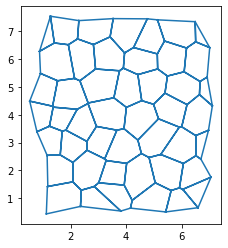

In [83]:
# create 2d patch of cell
sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
sgeom.update_all(sheet)

sheet.remove(sheet.cut_out([[0, 8], [0, 8]]), trim_borders=True)
sheet.sanitize()
sgeom.scale(sheet, 1/np.sqrt(sheet.face_df.area.mean()), ['x', 'y'])
sgeom.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
fig, ax = sheet_view(sheet, mode="quick")

### Quasistatic gradient descent


In [ ]:
effectors.

In [84]:
# Here we define our custom mode with 3 terms

model = model_factory(
    [effectors.PerimeterElasticity,
     effectors.LineTension,
     effectors.FaceAreaElasticity])


# setting up values for the whole epithelium
model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.05, # 1/2r in the master equation
        'prefered_perimeter': 3.81,
        "id": sheet.face_df.index
        },
    
    'vert': {
        "viscosity": 1.0
        },
    'edge': {
        "line_tension": 0.0,
        'is_active': 1
    },
    'settings': {
        'temperature': 2e-1, # See bellow
        "p_4": 10.0, # From Finegann et al.
        "p_5p": 1.0,
        "threshold_length": 2e-2
    }
}

sheet.update_specs(model_specs, reset=True)

res = QSSolver().find_energy_min(sheet, sgeom, model)

print(res.message)

Reseting column id of the face dataset with new specs


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


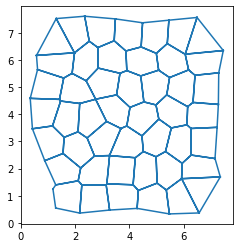

In [85]:
fig, ax = sheet_view(sheet, mode="quick")

In [86]:
# Save the original sheet in a backup objet
bck = sheet.copy()

## Define a Brownian motion effector




In [87]:
from tyssue.dynamics import effectors, units
from tyssue.utils import to_nd

# Adding some gigling
class BrownianMotion(effectors.AbstractEffector):
    
    label = 'Brownian Motion'
    element = 'vert'
    specs = {"settings": {"temperature": 1e-3}}
    
    def energy(eptm):
        T = eptm.settings['temperature']
        return np.ones(eptm.Nv) * T
    
    def gradient(eptm):
        T = eptm.settings['temperature']
        scale = T/eptm.edge_df.length.mean()
        
        grad = pd.DataFrame(
            data=np.random.normal(0, scale=scale, size=(eptm.Nv, eptm.dim)),
            index=eptm.vert_df.index,
            columns=['g'+c for c in eptm.coords]
        )
        return grad, None

## Coarse tracking model

In [88]:
def tract(eptm, face, pull_axis, value, pull_column='line_tension', face_id=None):
    """Modeling face traction as shrinking apical junctions on the neighouring cells,
    
    As if pseudopods where pulling between the cells
    
    
    """
    
    
    pull_axis = np.asarray(pull_axis)
    edges = eptm.edge_df.query(f'face == {face}')
    verts = edges['srce'].values
    r_ai = edges[["r"+c for c in eptm.coords]].values
    proj = (r_ai * pull_axis[None, :]).sum(axis=1)
    
    pulling_vert = verts[np.argmax(proj)]
    
    v_edges = eptm.edge_df.query(
        f"(srce == {pulling_vert}) & (face != {face})"
    )
    pulling_edges = v_edges[~v_edges['trgt'].isin(verts)].index
    eptm.edge_df[pull_column] = 0

    if pulling_edges.size:
        eptm.edge_df.loc[pulling_edges, pull_column] = value
        
        
default_traction_spec = {
    "face": -1,
    "face_id": -1,
    "pull_axis": [0.2, 0.8],
    "value": 4,
    "pull_column": "line_tension"
}


from tyssue.utils.decorators import face_lookup

@face_lookup
def traction(sheet, manager, **kwargs):
    
    traction_spec = default_traction_spec
    traction_spec.update(**kwargs)
    pulling = tract(sheet, **traction_spec)
    
    manager.append(traction, **traction_spec)

## Running the simulation

In [90]:

pulled = 2

model = model_factory(
    [effectors.PerimeterElasticity,
     effectors.LineTension,
     effectors.FaceAreaElasticity,
     BrownianMotion
    ])

# Euler solver + manager

# This allows to auomaticaly solve topology changes

manager = EventManager("face", )
manager.append(basic_events.reconnect)
manager.append(traction, face_id=pulled)

# Implicit Euler solver


### Implicit Euler solver

Force is the oposite of the gradient:

$$\mathbf{F} = -\mathbf{\nabla} E$$

The fundamental principle of dynamics says (in our inertia-less world):

$$\sum \mathbf{F} = 0$$


We can approximate the movement of the vertices as movement through an overdamping viscous medium. The viscous drag is then $F_d = - \eta \mathbf{v}$, where v is the speed of the vertex. So our expression above becomes:

$$\eta \mathbf{v} = \sum \mathbf{F}$$

(Now the sum is over all the _other_ force).

We can solve this system in the simplest way possible by a forward Euler method:

\begin{eqnarray}
\eta \mathbf{v} &=& \sum \mathbf{F}\\
\eta \frac{d}{dt}\mathbf{r} &=& \sum \mathbf{F}\\
\mathbf{r}(t + dt) &=& \mathbf{r}(t) + dt \, \frac{1}{\eta}\sum \mathbf{F}  \\
\end{eqnarray}


As we already know how to compute the model's gradient, implementing an Euler solver is not too complicated, and we can reuse our already existing model.


In [91]:

solver = EulerSolver(
    sheet,
    sgeom,
    model,
    manager=manager,
    bounds=(
        -sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10
    )
)
manager.update()


sheet.face_df['prefered_perimeter'] = 3.8

In [92]:
solver.solve(tf=100.0, dt=0.1)

highlight_faces(sheet.face_df, [pulled,], reset_visible=True)

fig, ax = sheet_view(
    sheet,
    mode="2D",
    face={"visible": True},
    edge={"head_width": 0.0, "color": sheet.edge_df["line_tension"]},
    vert={"visible": False}
)
fig.set_size_inches(6, 6)

KeyboardInterrupt: 

**Note** It is not trivial to use existing solver (from e.g. `scipy.integrate.ode`) because the **structure of the system of equations changes** during the course of the simulation!

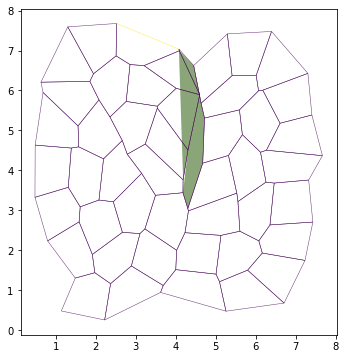

In [95]:
highlight_faces(sheet.face_df, [pulled,], reset_visible=True)

fig, ax = sheet_view(
    sheet,
    mode="2D",
    face={"visible": True},
    edge={"head_width": 0.0, "color": sheet.edge_df["line_tension"]},
    vert={"visible": False}
)
fig.set_size_inches(6, 6)

In [96]:
create_gif(solver.history, "migration.gif", num_frames=60, face={"visible": True})

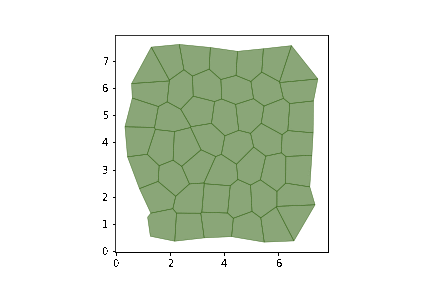

In [97]:
display.Image("migration.gif")

> **exercice**
>
> What is needed to make a paper out of that first experiment? 
> Discuss a paramter exploration plan
>
> Can we get back to physics to anticipate pertinent ranges for the parameters?
> 
> What relevant biology experiment would you run?


#### Using `history`

We can use the `History` object to look at what happened in the course of the simulation

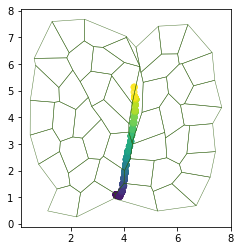

In [98]:

traj = solver.history.face_h.query('id == 2')[['time', 'x', 'y']]

fig, ax = sheet_view(sheet)
ax.scatter(traj.x, traj.y, c=traj.time, alpha=0.5)


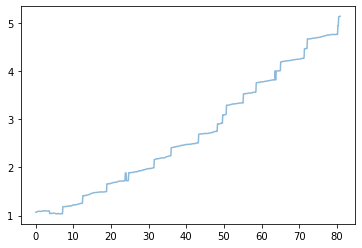

In [99]:
fig, ax = plt.subplots()

ax.plot(traj.time, traj.y, alpha=0.5)